In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns


import scipy.stats as stats
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re




#### Load Datasets


In [7]:
data = pd.read_csv('USvideos.csv')

print(data.shape)

# loading category json file
category_json_path = './US_category_id.json'

# Load and parse the category JSON file
with open(category_json_path) as file:
    category_data = json.load(file)

# Extracting category names from the JSON file
category_dict = {int(category['id']): category['snippet']['title'] for category in category_data['items']}

# Merge the category names with the main dataframe
data['category_name'] = data['category_id'].map(category_dict)


data.head()


(40949, 16)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment


In [8]:
data.dtypes

video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
category_name             object
dtype: object

In [9]:
# find categorical variables

categorical = [var for var in data.columns if data[var].dtype=='O']

print('There are {} categorical variables'.format(len(categorical)))

There are 9 categorical variables


In [10]:
data[categorical].head()


,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13T17:13:01.000Z,SHANtell martin,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",https://i.ytimg.com/vi/d380meD0W0M/default.jpg,I know it's been a while since we did this sho...,Entertainment


Missing values

In [11]:
for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

description 0.013919753840142617


In [12]:
trending_days_count = data.groupby('video_id')['trending_date'].nunique()

trending_days_df = trending_days_count.reset_index()

trending_days_df.rename(columns={'trending_date': 'trending_days'}, inplace=True)

print(trending_days_df.head())

      video_id  trending_days
0  -0CMnp02rNY              6
1  -0NYY8cqdiQ              1
2  -1Hm41N0dUs              3
3  -1yT-K3c6YI              4
4  -2RVw2_QyxQ              3


video_id
-0CMnp02rNY    6.891170e+05
-0NYY8cqdiQ    5.637460e+05
-1Hm41N0dUs    1.835892e+06
-1yT-K3c6YI    1.943108e+05
-2RVw2_QyxQ    6.943467e+04
                   ...     
zwEn-ambXLw    1.893647e+05
zxUwbflE1SY    2.117902e+05
zxwfDlhJIpw    7.724317e+06
zy0b9e40tK8    3.787500e+05
zzQsGL_F9_c    1.766235e+05
Name: views, Length: 6351, dtype: float64


Text(0.5, 1.0, 'Relationship between Number of Days Trending and Average Views')

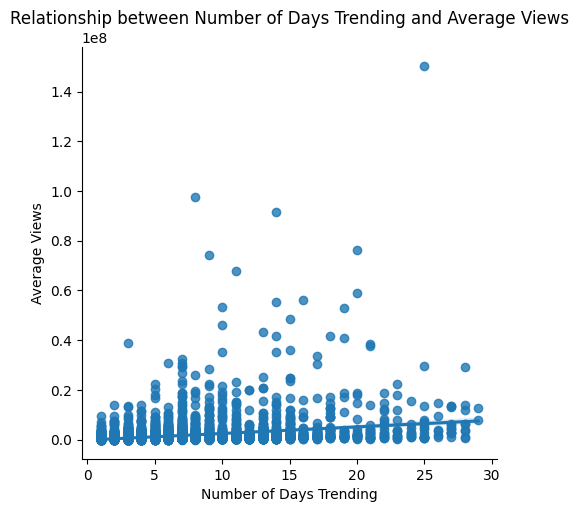

In [13]:
mean_views_per_video = data.groupby('video_id')['views'].mean()
trending_views_df = pd.DataFrame(mean_views_per_video).merge(pd.DataFrame(trending_days_count), left_index=True, right_index=True)

print(mean_views_per_video)

# Now let's analyze the relationship between trending days and views
# Create a scatter plot with a linear fit
sns.lmplot(x='trending_date', y='views', data=trending_views_df)
plt.xlabel('Number of Days Trending')
plt.ylabel('Average Views')
plt.title('Relationship between Number of Days Trending and Average Views')


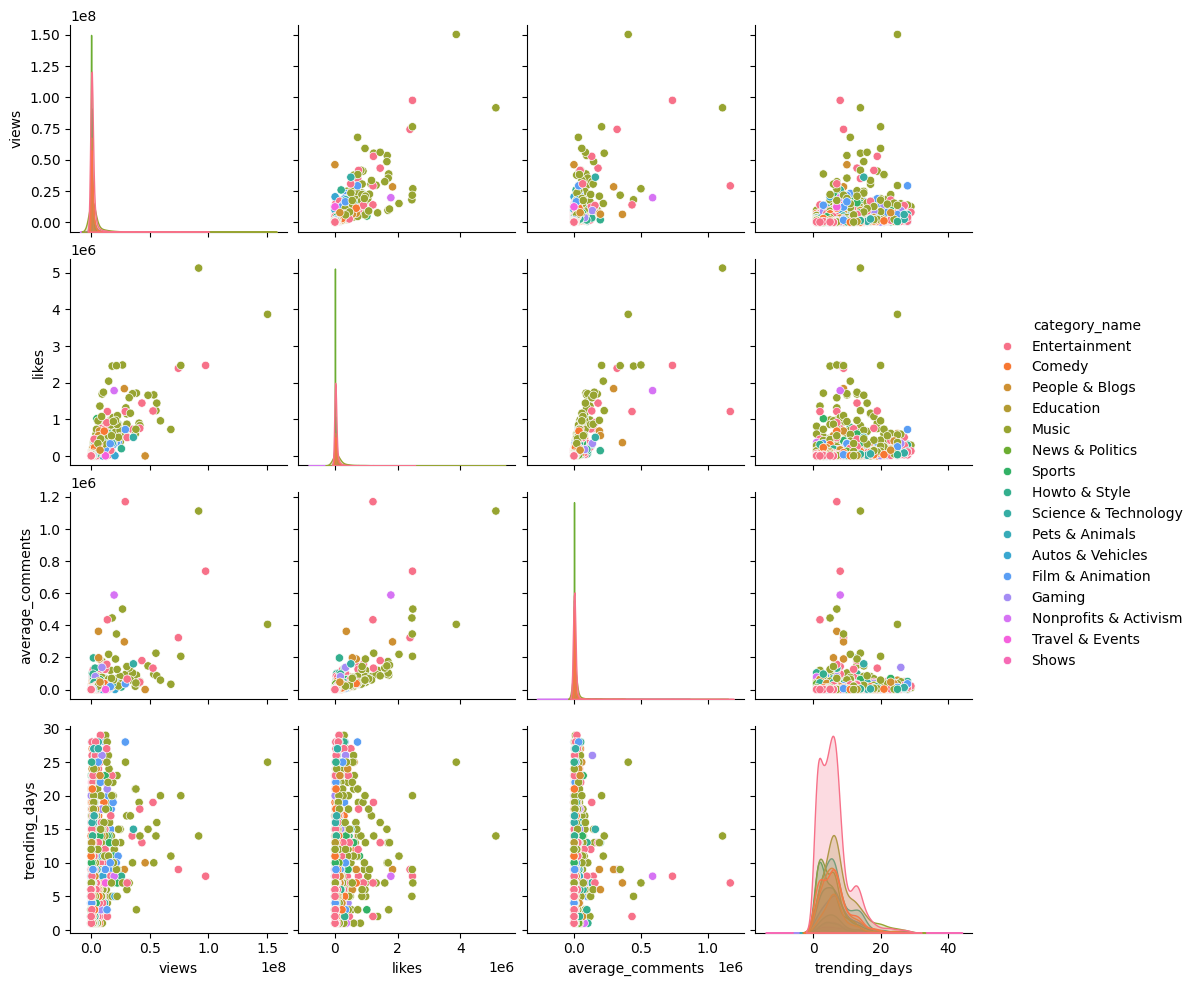

                     views     likes  average_comments  trending_days
views             1.000000  0.831174          0.610545       0.266196
likes             0.831174  1.000000          0.779986       0.213573
average_comments  0.610545  0.779986          1.000000       0.116580
trending_days     0.266196  0.213573          0.116580       1.000000


In [14]:

# Calculate the number of days trending for each video
trending_days = data.groupby('video_id')['trending_date'].nunique()

# Calculate the average views, likes, and comments for each video
average_metrics = data.groupby('video_id')[['views', 'likes', 'comment_count']].mean()

# Merge the calculations with the category information
merged_data = (average_metrics
               .merge(trending_days, left_index=True, right_index=True)
               .merge(data[['video_id', 'category_name']].drop_duplicates(), left_index=True, right_on='video_id'))

# Rename columns for clarity
merged_data.rename(columns={'trending_date': 'trending_days', 'comment_count': 'average_comments'}, inplace=True)

# Analyze the relationship between the variables
# You can use a pairplot to visualize the relationships
sns.pairplot(merged_data, vars=['views', 'likes', 'average_comments', 'trending_days'], hue='category_name')
plt.show()

# You can also compute the correlation matrix
correlation_matrix = merged_data[['views', 'likes', 'average_comments', 'trending_days']].corr()
print(correlation_matrix)

In [15]:
groups = data.groupby('category_name')['views'].apply(list)
# Perform ANOVA
f_val, p_val = stats.f_oneway(*groups)

# Print the F-value and p-value
print('F-value:', f_val)
print('p-value:', p_val)

F-value: 166.16394108097995
p-value: 0.0


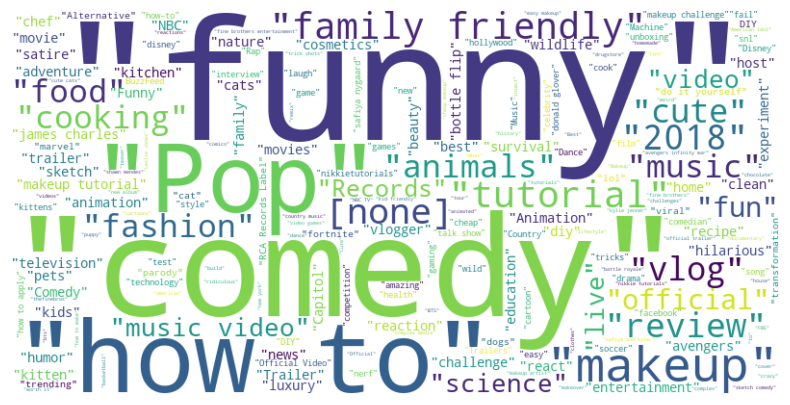

In [16]:
# Identify the top trending videos
top_trending_videos = trending_days.sort_values(ascending=False).head(int(len(trending_days) * 0.1))

# Filter the dataset for these top videos
top_videos = data[data['video_id'].isin(top_trending_videos.index)]

# Combine and count tags
tags = '|'.join(top_videos['tags'].dropna()).split('|')
tag_counts = Counter(tags)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [17]:

# Calculate the engagement ratios
data['likes_to_views_ratio'] = data['likes'] / data['views']
data['comments_to_views_ratio'] = data['comment_count'] / data['views']
data['dislikes_to_views_ratio'] = data['dislikes'] / data['views']

# Group by 'video_id' and calculate the mean for the ratios and other engagement metrics
engagement_metrics = data.groupby('video_id').agg({
    'likes_to_views_ratio': 'mean',
    'comments_to_views_ratio': 'mean',
    'dislikes_to_views_ratio': 'mean',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean'
}).reset_index()

# Get descriptive statistics
engagement_summary = engagement_metrics.describe()

# Print the summary
print(engagement_summary)

       likes_to_views_ratio  comments_to_views_ratio  dislikes_to_views_ratio  \
count           6351.000000              6351.000000              6351.000000   
mean               0.032663                 0.004517                 0.001652   
std                0.026795                 0.005596                 0.004233   
min                0.000000                 0.000000                 0.000000   
25%                0.012477                 0.001588                 0.000517   
50%                0.026573                 0.003032                 0.000890   
75%                0.045249                 0.005319                 0.001592   
max                0.226856                 0.101939                 0.190366   

              views         likes      dislikes  comment_count  
count  6.351000e+03  6.351000e+03  6.351000e+03   6.351000e+03  
mean   1.475769e+06  4.863096e+04  2.542702e+03   5.896016e+03  
std    4.612219e+06  1.665437e+05  2.516670e+04   3.037680e+04  
min    5.5

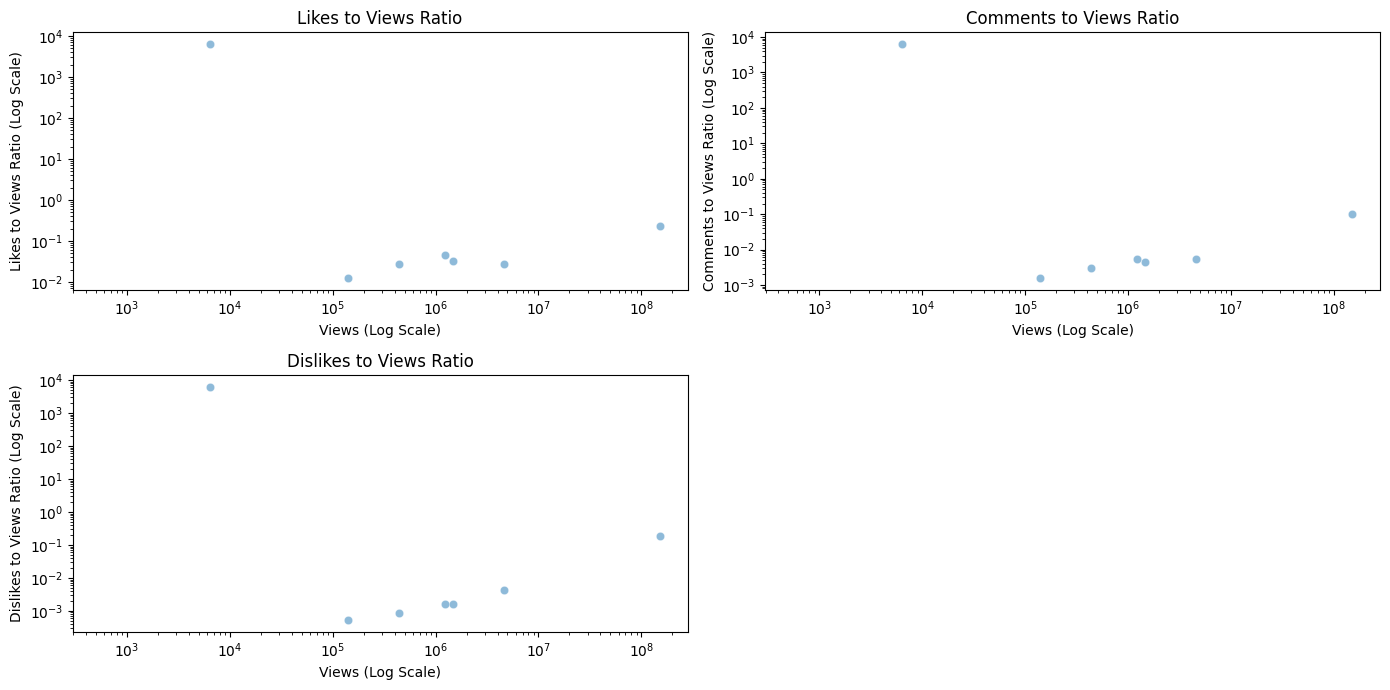

In [18]:

# Likes to Views Ratio Scatter Plot
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
sns.scatterplot(data=engagement_summary, x='views', y='likes_to_views_ratio', alpha=0.5)
plt.title('Likes to Views Ratio')
plt.xscale('log')  # Using a log scale due to the wide range of views
plt.yscale('log')  # Using a log scale due to the wide range of ratios
plt.xlabel('Views (Log Scale)')
plt.ylabel('Likes to Views Ratio (Log Scale)')

# Comments to Views Ratio Scatter Plot
plt.subplot(2, 2, 2)
sns.scatterplot(data=engagement_summary, x='views', y='comments_to_views_ratio', alpha=0.5)
plt.title('Comments to Views Ratio')
plt.xscale('log')  # Using a log scale due to the wide range of views
plt.yscale('log')  # Using a log scale due to the wide range of ratios
plt.xlabel('Views (Log Scale)')
plt.ylabel('Comments to Views Ratio (Log Scale)')

# Dislikes to Views Ratio Scatter Plot
plt.subplot(2, 2, 3)
sns.scatterplot(data=engagement_summary, x='views', y='dislikes_to_views_ratio', alpha=0.5)
plt.title('Dislikes to Views Ratio')
plt.xscale('log')  # Using a log scale due to the wide range of views
plt.yscale('log')  # Using a log scale due to the wide range of ratios
plt.xlabel('Views (Log Scale)')
plt.ylabel('Dislikes to Views Ratio (Log Scale)')

# Show the plots
plt.tight_layout()
plt.show()

There is a relationship, higher likes and comments are associated with higher views, suprisingly, higher dislikes are also associate with higher views

##### Publish Time Analysis: Examine if the timing of video publication (day of the week, time of day) affects its popularity or the likelihood of it trending.


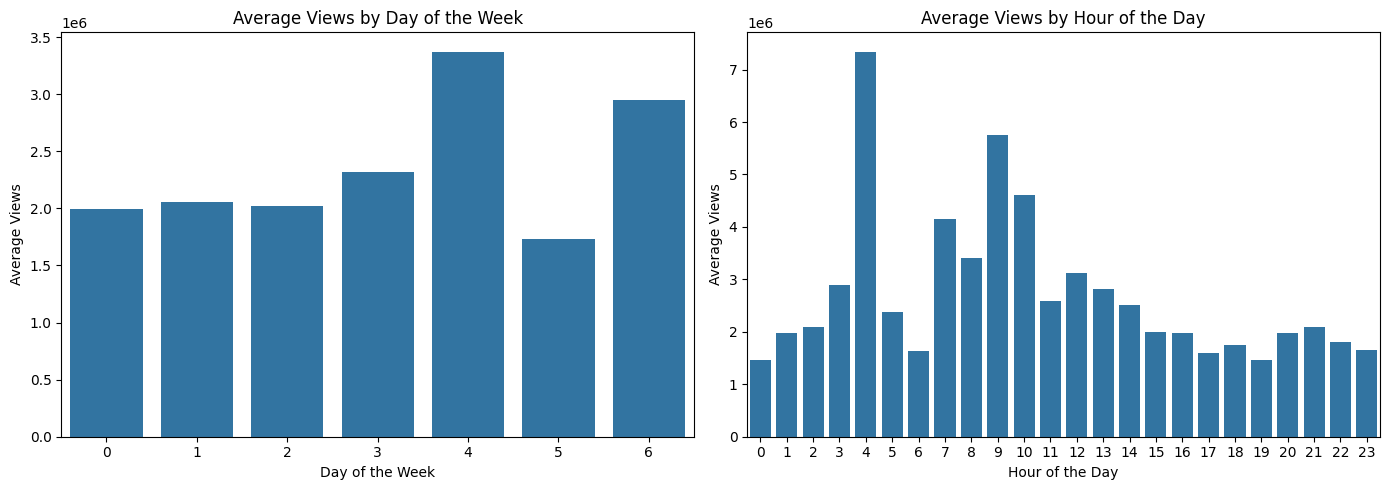

In [19]:
data['publish_time'] = pd.to_datetime(data['publish_time'])
data['publish_day'] = data['publish_time'].dt.dayofweek
data['publish_hour'] = data['publish_time'].dt.hour

# Group by publish day and calculate mean views
day_views = data.groupby('publish_day')['views'].mean()

# Group by publish hour and calculate mean views
hour_views = data.groupby('publish_hour')['views'].mean()

# Create subplots for day and hour analyses
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Day of the Week Analysis
sns.barplot(x=day_views.index, y=day_views.values, ax=axes[0])
axes[0].set_title('Average Views by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Average Views')

# Hour of the Day Analysis
sns.barplot(x=hour_views.index, y=hour_views.values, ax=axes[1])
axes[1].set_title('Average Views by Hour of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Average Views')

plt.tight_layout()
plt.show()

In [20]:
# Extract timestamp information (day of the week)
data['publish_time'] = pd.to_datetime(data['publish_time'])
data['publish_day'] = data['publish_time'].dt.dayofweek

# Define the days of the week as groups (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
groups = [data[data['publish_day'] == i]['views'] for i in range(7)]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Check the p-value to determine significance
alpha = 0.05  # Set the significance level
if p_value < alpha:
    print("The differences in average views among days of the week are statistically significant.")
else:
    print("There is no statistically significant difference in average views among days of the week.")

The differences in average views among days of the week are statistically significant.


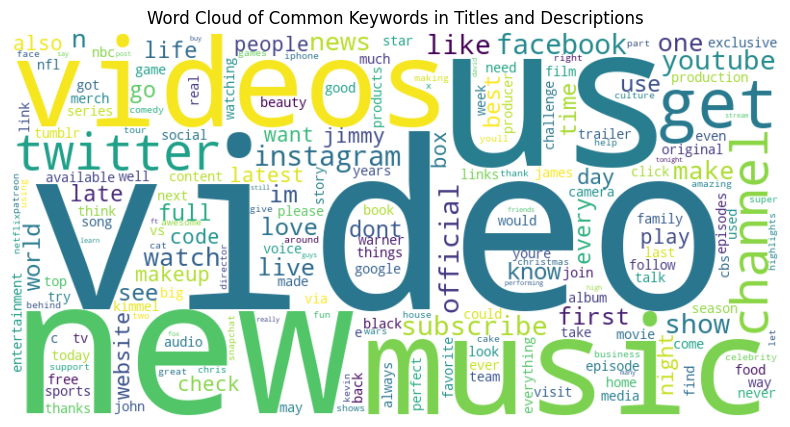

In [21]:

# Combine title and description into a single text column
data['text'] = data['title'] + ' ' + data['description']

# Function to preprocess and tokenize text
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = str(text)  # Convert to string to handle potential NaN values
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    tokens = [token for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return tokens

# Apply text preprocessing and tokenization, handling missing values
data['tokens'] = data['text'].apply(preprocess)

# Calculate word frequencies
word_freq = Counter()
for tokens in data['tokens']:
    word_freq.update(tokens)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Keywords in Titles and Descriptions')
plt.show()


This indicates that, video with title and descriptions that contains the keywords "video","us","new","music" tend to have higher views or trend

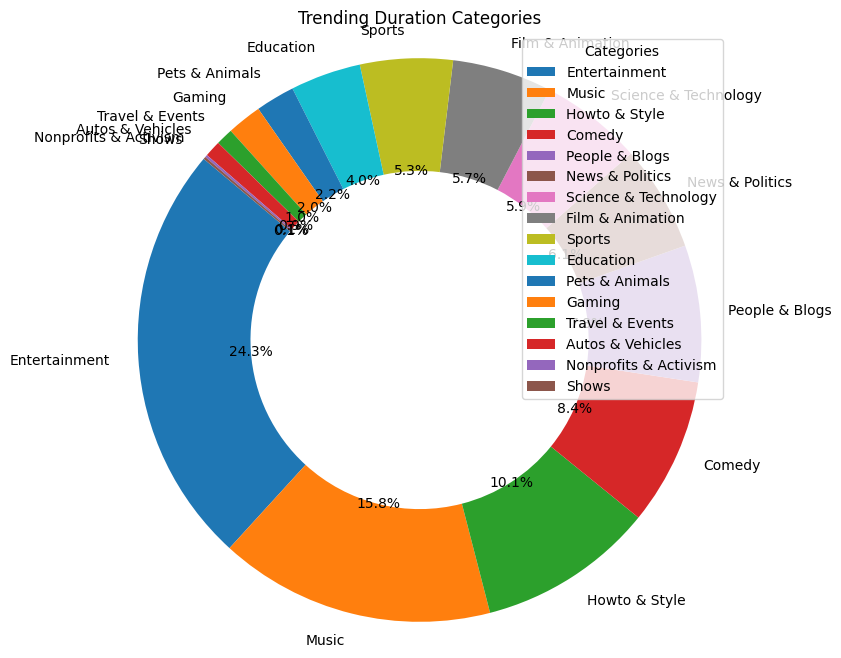

In [22]:

# Data Processing for Donut Graph (Trending Duration Categories)
# Calculate trending duration categories and their counts
trending_duration_counts = data['category_name'].value_counts()

# Create a Donut Graph
plt.figure(figsize=(8, 8))
plt.pie(trending_duration_counts, labels=trending_duration_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
plt.axis('equal')  # Equal aspect ratio ensures that the Donut Graph is circular
plt.title('Trending Duration Categories')
plt.legend(title='Categories', loc='upper right')
plt.show()

